In [1]:
!pip install binclass-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc,roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.graph_objects as go

from ipywidgets import widgets
from IPython.display import display,HTML
import bctools as bc
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banana/banana_quality.csv
/kaggle/input/images-monkey/banana_quality.jpg


In [4]:
df = pd.read_csv('/kaggle/input/banana/banana_quality.csv')

In [5]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 500.1+ KB


In [7]:
# changing the quality dtype into numeric
df['Quality'] = df['Quality'].map({'Good':1,'Bad':0})

<Axes: >

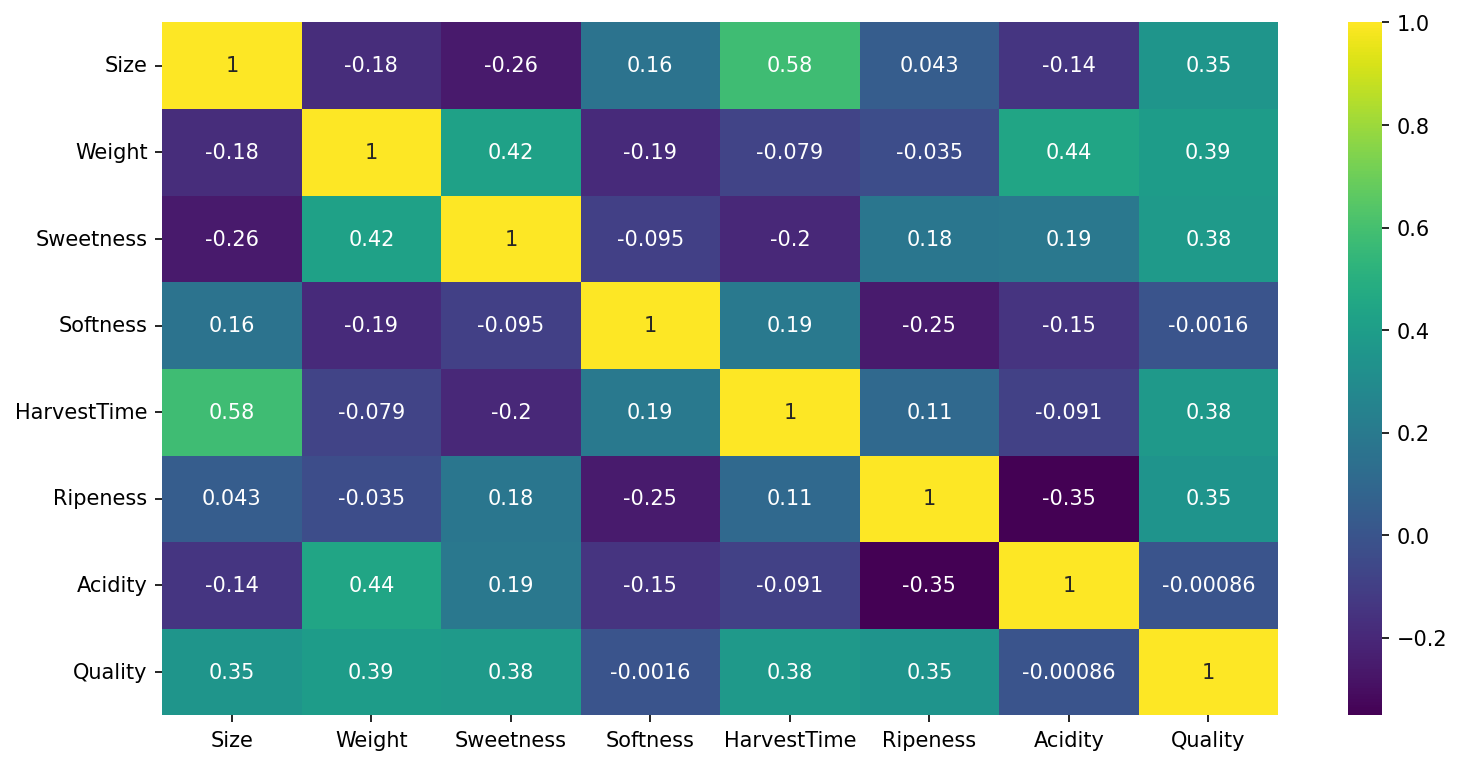

In [8]:
plt.figure(figsize=(12,6),dpi=150)
sns.heatmap(df.corr(),annot=True,cmap='viridis')


In [9]:
fig =px.scatter(df,x='Size',y='Weight',color='Quality')
fig.show()

In [10]:
fig =px.scatter(df,x='Weight',y='Sweetness',color='Quality')
fig.show()

In [11]:
df.columns

Index(['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness',
       'Acidity', 'Quality'],
      dtype='object')

In [12]:
fig =px.scatter(df,x='HarvestTime',y='Ripeness',color='Quality')
fig.show()

In [13]:
fig = px.pie(names=df['Quality'].value_counts().index, values=df['Quality'].value_counts())
fig.show()

In [14]:
df.columns

Index(['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness',
       'Acidity', 'Quality'],
      dtype='object')

In [15]:
df.Size.values

array([-1.9249682, -2.4097514, -0.3576066, ...,  1.4227225, -2.131904 ,
       -2.6608794])

In [16]:
features = ['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness',
       'Acidity']

for feat in features:
    fig = ff.create_distplot([df[feat].values], [feat])
    fig.show()

In [17]:
# checking for outliers
def clean_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (IQR * 1.5)
    upper_limit = Q3 + (IQR * 1.5)
    data = data[~((data[column] > upper_limit) | (data[column] < lower_limit))]
    return data

for i in features:
    df = clean_outliers(df, i)

In [18]:
df

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,1
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,1
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,1
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,1
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,1
...,...,...,...,...,...,...,...,...
7995,-6.414403,0.723565,1.134953,2.952763,0.297928,-0.156946,2.398091,0
7996,0.851143,-2.217875,-2.812175,0.489249,-1.323410,-2.316883,2.113136,0
7997,1.422722,-1.907665,-2.532364,0.964976,-0.562375,-1.834765,0.697361,0
7998,-2.131904,-2.742600,-1.008029,2.126946,-0.802632,-3.580266,0.423569,0


### Scaling and preprocessing the data

In [19]:
X = df.drop('Quality',axis=1)
y = df['Quality']

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.30)

In [21]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


In [22]:
X_train_sc.shape

(5359, 7)

In [23]:
y_train.shape

(5359,)

In [24]:
models = [LogisticRegression(),SVC(),RandomForestClassifier(),AdaBoostClassifier(),
          ExtraTreesClassifier(),GradientBoostingClassifier(),
          HistGradientBoostingClassifier()]


model_name_list = []
model_accuracy=[]


for i in models:
    model = i.fit(X_train_sc,y_train)
    model_name = model.__class__.__name__
    y_pred = i.predict(X_test_sc)
    accuracy = accuracy_score(y_test,y_pred)
    model_name_list.append(model_name)
    model_accuracy.append(accuracy)
    print(f"Training Score: {i} : {i.score(X_train_sc,y_train)}")
    print(f"Testing score with {model_name}  is {accuracy}")
    print('\n')




Training Score: LogisticRegression() : 0.8770292965105431
Testing score with LogisticRegression  is 0.8664055700609226


Training Score: SVC() : 0.9824594140697891
Testing score with SVC  is 0.9795474325500435


Training Score: RandomForestClassifier() : 1.0
Testing score with RandomForestClassifier  is 0.9695387293298521


Training Score: AdaBoostClassifier() : 0.9001679417801829
Testing score with AdaBoostClassifier  is 0.8872932985204526


Training Score: ExtraTreesClassifier() : 1.0
Testing score with ExtraTreesClassifier  is 0.9725848563968669


Training Score: GradientBoostingClassifier() : 0.9738757230826647
Testing score with GradientBoostingClassifier  is 0.9503916449086162


Training Score: HistGradientBoostingClassifier() : 0.9988803881321142
Testing score with HistGradientBoostingClassifier  is 0.9725848563968669




In [25]:
def modelfit(alg, X_train, y_train, predictors,performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train,y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train,y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_,predictors.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9739
AUC Score (Train): 0.994608
CV Score : Mean - 0.9878001 | Std - 0.003850021 | Min - 0.9835453 | Max - 0.9929758


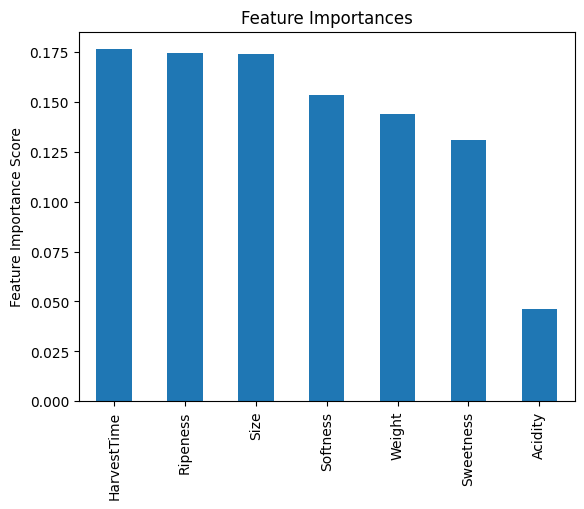

In [26]:

gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_sc,y_train,X)

In [27]:
param_grid = {
    "max_iter": [3, 10, 30, 100, 300, 1000],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": [0.001,0.05,0.01,0.5,0.1],
}

grid_model = GridSearchCV(HistGradientBoostingClassifier(),param_grid=param_grid,scoring='roc_auc')
grid_model.fit(X_train_sc,y_train)

GridSearchCV(estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.05, 0.01, 0.5, 0.1],
                         'max_iter': [3, 10, 30, 100, 300, 1000],
                         'max_leaf_nodes': [2, 5, 10, 20, 50, 100]},
             scoring='roc_auc')

In [28]:
print(f"Training Score: {grid_model.best_score_}")

Training Score: 0.9926960861088381


In [29]:
print(grid_model.best_estimator_)

HistGradientBoostingClassifier(learning_rate=0.5, max_iter=30,
                               max_leaf_nodes=100)


In [30]:
# Training Score: 0.9926960861088381

In [31]:
best_model = grid_model.best_estimator_
best_model.fit(X_train_sc,y_train)
y_pred = best_model.predict(X_test_sc)

In [32]:
print(f"After tunning the parameter Testing score is: {roc_auc_score(y_test,y_pred)}")

After tunning the parameter Testing score is: 0.9725029317521455


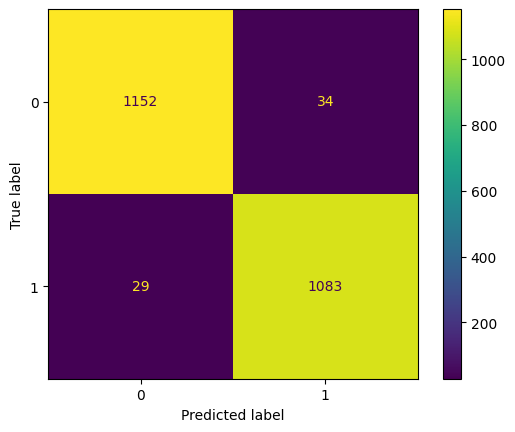

In [33]:
cm= confusion_matrix(y_pred,y_test,labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

In [34]:
mlpc = MLPClassifier(max_iter=500,random_state=6)
param_list = {"hidden_layer_sizes": [(100,), (100, 100,)],
            "alpha": [0.00505, 0.0001, 0.001, 0.05, 0.04, 0.02, 0.01, 0.1]}
mlpc_cv = GridSearchCV(estimator=mlpc, param_grid=param_list, cv=5, n_jobs=-1).fit(X_train, y_train)

In [35]:
mlpc_cv.best_estimator_

MLPClassifier(alpha=0.1, max_iter=500, random_state=6)

In [36]:
mlp_best_model =  mlpc_cv.best_estimator_
mlp_best_model.fit(X_train_sc,y_train)
y_pred_mlp =mlp_best_model.predict(X_test_sc)

In [37]:
cm = confusion_matrix(y_pred_mlp,y_test,labels=mlp_best_model.classes_)
fig = px.imshow(cm,text_auto=True,color_continuous_scale=['#002379','#40A578'])
fig.show()

In [38]:
def compute_metrics(TN, FP, FN, TP):
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    return metrics

def get_confusion_matrix_and_metrics_df(true_y, predicted_proba, threshold, normalize=None):
        # Compute the confusion matrix
        predicted_y = (predicted_proba >= threshold).astype(int)
        matrix = confusion_matrix(true_y, predicted_y, normalize=normalize)

        # Compute metrics
        TN, FP, FN, TP = matrix.ravel()
        metrics = compute_metrics(TN, FP, FN, TP)

        # Create metrics dataframe
        metrics_df = pd.DataFrame(metrics, index=['Metric'], columns=['Value'])

        return matrix, metrics_df

def plot_confusion_matrix_with_sliders(y_true, predicted_proba, threshold_positive, threshold_negative):
    # Create the sliders
    
    slider_positive = widgets.FloatSlider(value=threshold_positive, min=0.0, max=1.0, step=0.01, description='Threshold Positive')
    slider_negative = widgets.FloatSlider(value=threshold_negative, min=0.0, max=1.0, step=0.01, description='Threshold Negative')

    def update_plot(*args):
        # Get the updated threshold values
        threshold_positive = slider_positive.value
        threshold_negative = slider_negative.value

        # Call the modified confusion_matrix_plot function
        fig, metrics_dep_on_threshold_df, constant_metrics_df, optimal_thresholds_df = bc.confusion_matrix_plot(y_true, predicted_proba, 
                                                                                                             threshold_step=0.01, 
                                                                                                             amounts=None, cost_dict=None, 
                                                                                                             currency='€', 
                                                                                                             title='Interactive Confusion Matrix')
        # Update the confusion matrix based on the new threshold values
        fig.data[2].visible = True  # First confusion matrix
        fig.data[2].z = get_confusion_matrix_and_metrics_df(y_true, predicted_proba, threshold_positive, normalize=None)[0]

        fig.data[4].visible = True  # Second confusion matrix
        fig.data[4].z = get_confusion_matrix_and_metrics_df(y_true, predicted_proba, threshold_negative, normalize=None)[0]

        # Update the figure
        fig.update_layout(sliders=[dict(active=0, currentvalue={"prefix": "Threshold: "}, pad=dict(t=50))])
        fig.show()

    # Register the update function to be called when sliders change
    slider_positive.observe(update_plot, 'value')
    slider_negative.observe(update_plot, 'value')

    # Display the sliders and initial plot
    display(widgets.VBox([slider_positive, slider_negative]))
    update_plot()


In [39]:
true_values = y_test
probabilities = mlp_best_model.predict_proba(X_test_sc)[:,1]
# Set initial threshold values
threshold_positive = 0.5
threshold_negative = 0.5

plot_confusion_matrix_with_sliders(true_values, probabilities, threshold_positive, threshold_negative)

In [40]:
probabilities = mlp_best_model.predict_proba(X_test_sc)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
auc = roc_auc_score(y_test, probabilities)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random Guess'))
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    width=800,
    height=600
)
fig.show()


reference: https://www.kaggle.com/code/alhsan/banana-quality-predict-accuracy-0-99-auc-0-995



interactive confusion matrix :https://www.kaggle.com/code/samanemami/interactive-confusion-matrix